# Probe the No Evaporation Model (Temp + Precip)

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/ensemble_NO_EVAP/lstm_ensemble1_NO_EVAP_1606_014459"
# run_dir = data_dir / "runs/complexity_AZURE/hs_064_0306_205514"

out_dir = run_dir / "cell_states"

In [3]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = Path("/home/tommy/spatio_temporal/data")
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

In [4]:
# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

cfg.dynamic_inputs

['precipitation', 'temperature']

# Probe Targets

In [5]:
# SNOW + SM
era5filepath = (data_dir / "camels_basin_ERA5Land_sm.nc")
era5_sm = xr.open_dataset(era5filepath).drop("spatial_ref")

from scripts.cell_state.normalize import normalize_2d_dataset

if not isinstance(era5_sm, xr.Dataset):
    era5_sm = era5_sm.to_dataset()

for var in era5_sm.data_vars:
    era5_sm[var] = normalize_2d_dataset(era5_sm, variable_str=var, per_basin=True)

Normalising each station:   0%|          | 0/670 [00:00<?, ?it/s]/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/extmath.py:709: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs, dtype=np.float64)
Normalising each station:   0%|          | 0/670 [00:00<?, ?it/s]/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/extmath.py:770: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/tommy/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/utils/extmath.py:709: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs, dtype=np.float64)
Normalising each station:   0%|          | 0/670 [00:00<?, ?it/s]/home/t

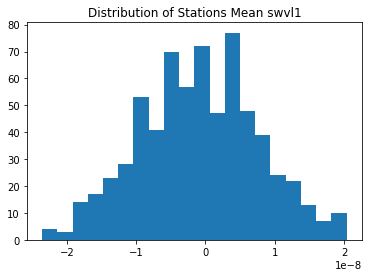

In [6]:
f, ax = plt.subplots()
ax.hist(era5_sm["swvl1"].mean(dim="time").values, bins=20);
ax.set_title("Distribution of Stations Mean swvl1");

# Get cell state data

In [7]:
from scripts.cell_state.extract_cell_state import get_cell_states

out_dir = run_dir / "cell_states"

if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

if not (out_dir / "cell_states.nc").exists():
    cn = get_cell_states(cfg, run_dir)
    cn.to_netcdf(out_dir / "cell_states.nc")
else:
    cn = xr.open_dataset(out_dir / "cell_states.nc")

In [8]:
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable

# New data
station_dim = "station_id"
time_dim = "date"

# normalize ???
mean_ = cn.mean(dim=[station_dim, time_dim])
std_ = cn.std(dim=[station_dim, time_dim])
norm_cs_data = (cn - mean_) / std_
# or per station-dimension
# norm_cs_data = 

cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
    time_dim="date",
).rename({"date": "time"})
cs["station_id"] = cs["station_id"].astype(int)

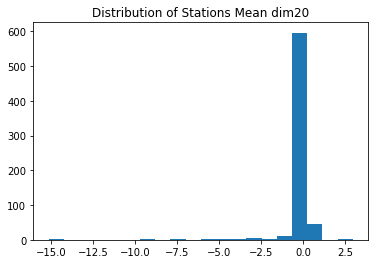

In [9]:
f, ax = plt.subplots()
ax.hist(cs["dim20"].mean(dim="time").values, bins=20);
ax.set_title("Distribution of Stations Mean dim20");

# Create Probe Samples

In [10]:
from collections import defaultdict 
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset
from scripts.cell_state.timeseries_dataset import get_data_samples, get_time_basin_aligned_samples, get_time_basin_aligned_dictionary

target_ds = era5_sm
input_ds = cs

train_start_date: pd.Timestamp = pd.to_datetime("1998-01-01")
train_end_date: pd.Timestamp = pd.to_datetime("2006-09-30")
test_start_date: pd.Timestamp = pd.to_datetime("2006-10-01")
test_end_date: pd.Timestamp =  pd.to_datetime("2009-10-01")
seq_length = 1
basin_dim = "station_id"
time_dim = "time"
input_variables = [f"dim{i}" for i in np.arange(64)]

# train test split
target_data = target_ds.sel(time=slice(train_start_date, train_end_date))
input_data = input_ds.sel(time=slice(train_start_date, train_end_date))

test_target_data = target_ds.sel(time=slice(test_start_date, test_end_date))
test_input_data = input_ds.sel(time=slice(test_start_date, test_end_date))


all_train_test = defaultdict(dict)
for target_var in target_data.data_vars:
    print(f"** STARTING {target_var} **")
    train_dataset = TimeSeriesDataset(
        input_data=input_data,
        target_data=target_data,
        target_variable=target_var,
        input_variables=input_variables,
        seq_length=seq_length,
        basin_dim=basin_dim,
        time_dim=time_dim,
        desc="Creating Train Samples",
    )

    train = get_time_basin_aligned_dictionary(train_dataset)

    test_dataset = TimeSeriesDataset(
        input_data=test_input_data,
        target_data=test_target_data,
        target_variable=target_var,
        input_variables=input_variables,
        seq_length=seq_length,
        basin_dim=basin_dim,
        time_dim=time_dim,
        desc="Creating Test Samples",
    )

    test = get_time_basin_aligned_dictionary(test_dataset)
    
    all_train_test[target_var]["train"] = train
    all_train_test[target_var]["test"] = test

** STARTING swvl1 **


Extracting Data: 100%|██████████| 8322/8322 [01:04<00:00, 129.40it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2142/2142 [00:15<00:00, 134.80it/s]


Merging and reshaping arrays
** STARTING swvl2 **


Extracting Data: 100%|██████████| 8322/8322 [01:03<00:00, 130.29it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2142/2142 [00:16<00:00, 131.12it/s]


Merging and reshaping arrays
** STARTING swvl3 **


Extracting Data: 100%|██████████| 8322/8322 [01:01<00:00, 135.62it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2142/2142 [00:15<00:00, 135.40it/s]


Merging and reshaping arrays
** STARTING swvl4 **


Extracting Data: 100%|██████████| 8322/8322 [01:02<00:00, 133.72it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2142/2142 [00:15<00:00, 139.31it/s]


Merging and reshaping arrays
** STARTING sd **


Extracting Data: 100%|██████████| 8322/8322 [01:01<00:00, 135.82it/s]


Merging and reshaping arrays


Extracting Data: 100%|██████████| 2142/2142 [00:15<00:00, 135.55it/s]


Merging and reshaping arrays


# Fit and Predict all Probe Samples

In [11]:
# fit and predict all linear probes
from scripts.cell_state.sklearn_models import (
    init_linear_model,
    evaluate,
    create_analysis_dataset,
    fit_and_predict,
)

all_models_preds = defaultdict(dict)
target_vars = [v for v in target_data.data_vars]

for target_var in target_vars:
    print(f"** {target_var} **")
    model, preds, errors = fit_and_predict(all_train_test[target_var]["train"], all_train_test[target_var]["test"], random_seed=100)
    all_models_preds[target_var]["model"] = model
    all_models_preds[target_var]["preds"] = preds
    all_models_preds[target_var]["errors"] = errors

** swvl1 **
-- Epoch 1
Norm: 0.74, NNZs: 31, Bias: 0.122243, T: 1917358, Avg. loss: 0.036197
Total training time: 1.50 seconds.
-- Epoch 2
Norm: 0.74, NNZs: 30, Bias: 0.117347, T: 3834716, Avg. loss: 0.036151
Total training time: 3.20 seconds.
-- Epoch 3
Norm: 0.74, NNZs: 31, Bias: 0.120754, T: 5752074, Avg. loss: 0.036140
Total training time: 4.90 seconds.
-- Epoch 4
Norm: 0.74, NNZs: 33, Bias: 0.127692, T: 7669432, Avg. loss: 0.036148
Total training time: 6.58 seconds.
Convergence after 4 epochs took 6.77 seconds


Calculating Errors: 100%|██████████| 667/667 [00:08<00:00, 78.32it/s, 106001]


** swvl2 **
-- Epoch 1
Norm: 0.78, NNZs: 37, Bias: -0.053022, T: 1917358, Avg. loss: 0.031393
Total training time: 1.47 seconds.
-- Epoch 2
Norm: 0.78, NNZs: 36, Bias: -0.055219, T: 3834716, Avg. loss: 0.031343
Total training time: 3.20 seconds.
-- Epoch 3
Norm: 0.78, NNZs: 37, Bias: -0.055873, T: 5752074, Avg. loss: 0.031342
Total training time: 4.90 seconds.
-- Epoch 4
Norm: 0.77, NNZs: 37, Bias: -0.050822, T: 7669432, Avg. loss: 0.031342
Total training time: 6.57 seconds.
Convergence after 4 epochs took 6.76 seconds


Calculating Errors: 100%|██████████| 667/667 [00:08<00:00, 77.62it/s, 106001]


** swvl3 **
-- Epoch 1
Norm: 0.79, NNZs: 41, Bias: 0.148370, T: 1917358, Avg. loss: 0.032120
Total training time: 1.44 seconds.
-- Epoch 2
Norm: 0.79, NNZs: 42, Bias: 0.147145, T: 3834716, Avg. loss: 0.032070
Total training time: 3.06 seconds.
-- Epoch 3
Norm: 0.79, NNZs: 43, Bias: 0.145295, T: 5752074, Avg. loss: 0.032069
Total training time: 4.73 seconds.
-- Epoch 4
Norm: 0.79, NNZs: 41, Bias: 0.149337, T: 7669432, Avg. loss: 0.032064
Total training time: 6.31 seconds.
Convergence after 4 epochs took 6.50 seconds


Calculating Errors: 100%|██████████| 667/667 [00:08<00:00, 79.23it/s, 106001]


** swvl4 **
-- Epoch 1
Norm: 0.84, NNZs: 39, Bias: 0.107654, T: 1917358, Avg. loss: 0.043041
Total training time: 1.44 seconds.
-- Epoch 2
Norm: 0.83, NNZs: 41, Bias: 0.109379, T: 3834716, Avg. loss: 0.042959
Total training time: 3.08 seconds.
-- Epoch 3
Norm: 0.84, NNZs: 41, Bias: 0.108074, T: 5752074, Avg. loss: 0.042959
Total training time: 4.81 seconds.
-- Epoch 4
Norm: 0.84, NNZs: 41, Bias: 0.113103, T: 7669432, Avg. loss: 0.042957
Total training time: 6.44 seconds.
Convergence after 4 epochs took 6.61 seconds


Calculating Errors: 100%|██████████| 667/667 [00:08<00:00, 78.18it/s, 106001]


** sd **
-- Epoch 1
Norm: 0.22, NNZs: 32, Bias: -0.168676, T: 1917358, Avg. loss: 0.006459
Total training time: 1.52 seconds.
-- Epoch 2
Norm: 0.22, NNZs: 33, Bias: -0.168594, T: 3834716, Avg. loss: 0.006454
Total training time: 3.25 seconds.
-- Epoch 3
Norm: 0.22, NNZs: 31, Bias: -0.170020, T: 5752074, Avg. loss: 0.006454
Total training time: 4.92 seconds.
-- Epoch 4
Norm: 0.22, NNZs: 34, Bias: -0.168532, T: 7669432, Avg. loss: 0.006453
Total training time: 6.64 seconds.
Convergence after 4 epochs took 6.84 seconds


Calculating Errors: 100%|██████████| 667/667 [00:08<00:00, 78.74it/s, 106001]


In [56]:
from scripts.cell_state.analysis import (save_probe_components, load_probe_components)

save_probe_components(run_dir=run_dir, all_models_preds=all_models_preds)

# Explore Linear Probes

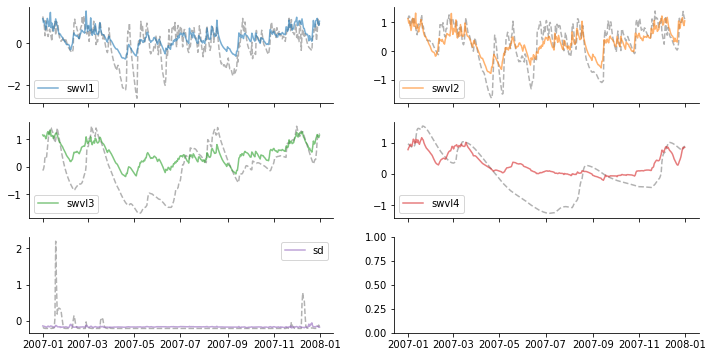

In [12]:
N = 1
pixels = np.random.choice(preds.station_id.values, N, replace=False)
time = "2007"

for px in pixels:
    f, axs = plt.subplots(3, 2, figsize=(12, 4*1.5), sharex=True)
    for ix, target_var in enumerate(target_vars):
        ax = axs[np.unravel_index(ix, (3, 2))]
        preds = all_models_preds[target_var]["preds"]
        data = preds.sel(station_id=px, time=time)

    #     f, ax = plt.subplots(figsize=(12, 4))
        ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3)
        ax.plot(data.time, data.sim, color=f"C{ix}", ls="-", alpha=0.6, label=f"{target_var}")
        ax.legend()
        sns.despine()

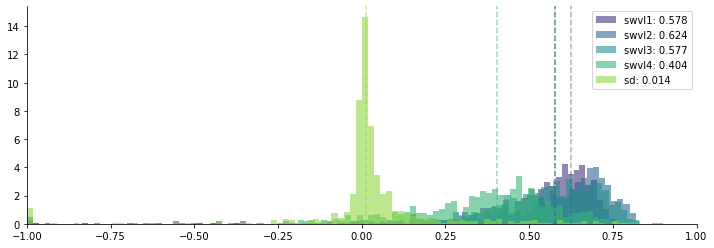

In [13]:
f, ax = plt.subplots(figsize=(12, 4))

colors = sns.color_palette("viridis", n_colors=len(target_vars))
for ix, target_var in enumerate(target_vars):
    errors = all_models_preds[target_var]["errors"]
    nse = errors["NSE"]

    ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.3f}", alpha=0.6, color=colors[ix]);
    ax.axvline(nse.median(), color=colors[ix], ls="--", alpha=0.5)

ax.set_xlim(-1, 1)
ax.legend()
sns.despine()

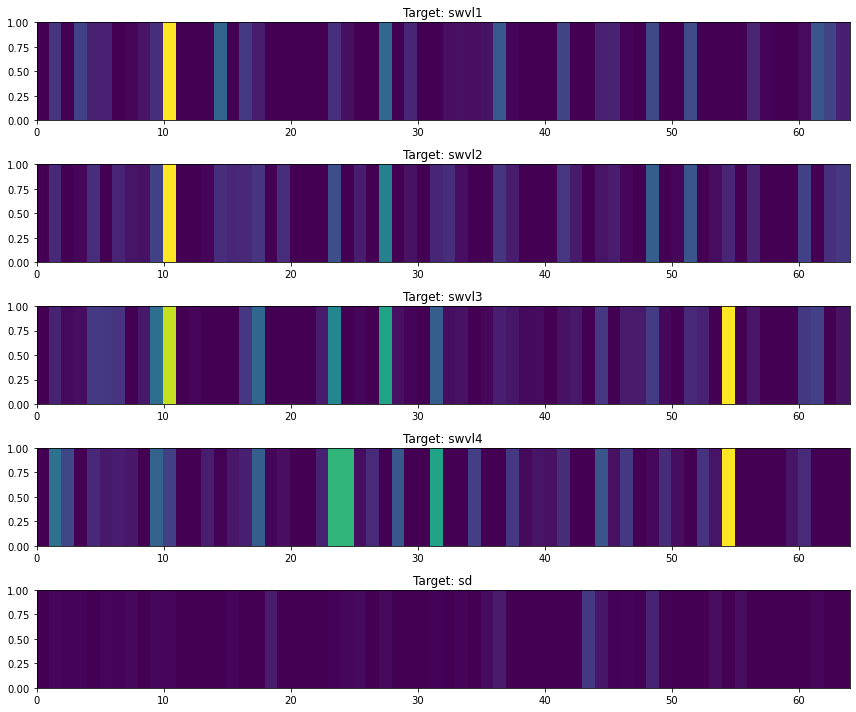

In [14]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

n_plots = len(target_vars)
f, axs = plt.subplots(n_plots, 1, figsize=(12, 2*n_plots))

for ix, target_var in enumerate(target_vars):
    model = all_models_preds[target_var]["model"]
    ax = axs[ix]
    w, b = get_model_weights(model)
    plot_weights(np.abs(w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=ax, cbar=False)
    ax.set_title(f"Target: {target_var}")
plt.tight_layout()

# What about the spatial performances?

In [15]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [16]:
points = load_latlon_points(Path("/home/tommy/spatio_temporal/data"))

Darker is Better (closer to NSE = 0.8)


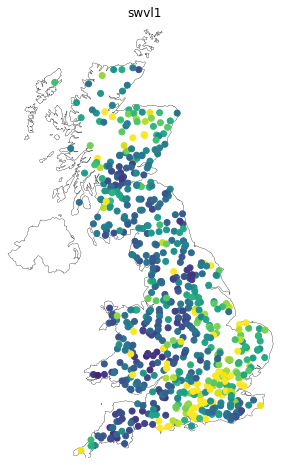

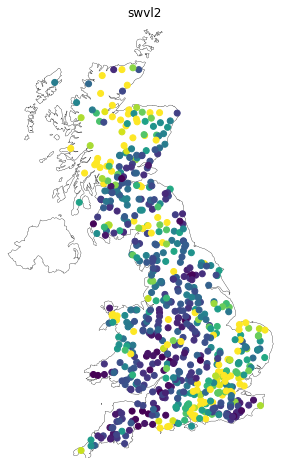

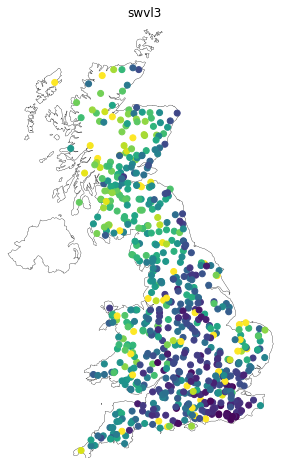

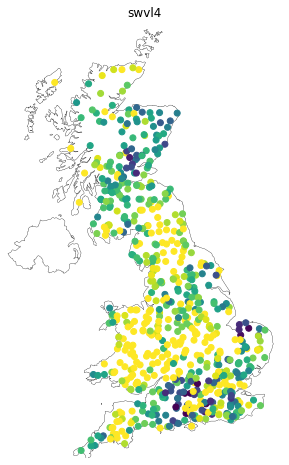

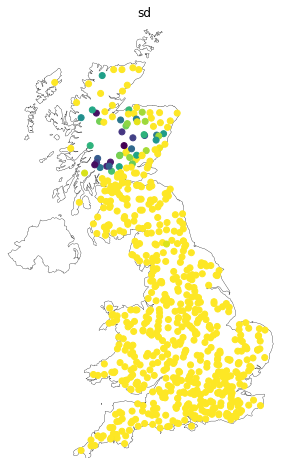

In [19]:
for target_var in target_vars:
    # initialise plotting data
    errors = all_models_preds[target_var]["errors"]
    gdf = gpd.GeoDataFrame(errors["NSE"].to_dataframe().join(points))
    
    # create plot
    ax = initialise_gb_spatial_plot()

    cbar = False
    vmax = 0.8
    vmin = 0.3

    if cbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        gdf.plot("NSE", ax=ax, vmin=vmin, vmax=vmax, cmap="viridis_r", cax=cax, legend=True);
    else:
        gdf.plot("NSE", ax=ax, vmin=vmin, vmax=vmax, cmap="viridis_r")
    
    ax.set_title(f"{target_var}")
    
print("Darker is Better (closer to NSE = 0.8)")